In [1]:
# %matplotlib_svg
%pylab inline
# import numpy as np
# from matplotlib import pyplot as plt
from matplotlib import collections as mc

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import sys 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../codes/")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../codes/scpy2/")))


In [3]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

plt.rcParams["font.family"] = "simsun" # 可以直接修改設定字典，設定預設字型，這樣就不需要在每次繪製文字時設定字型了
plt.rcParams['axes.unicode_minus']=False    # 當座標軸上的 負號無法正常顯示時，需加這行 code

In [4]:
from IPython.core.magic import register_line_magic

@register_line_magic
def dot(line):
    from IPython.core.getipython import get_ipython
    from fnmatch import fnmatch

    import pydotplus as pdp
    from IPython.display import display, Image

    line = line.strip()
    data = eval(line)

    graph = pdp.graph_from_dot_data(data)
    display(Image(graph.create_png()))

## 塊、路徑和集合

本節介紹組成繪畫元素的幾個重要的類別，熟練掌握這些類別的用法可以繪製出標準的繪圖函數無法實現的效果，並且能相當大地加強繪圖速度。

### Path與Patch

`Patch`物件(塊) 是一種擁有填充和邊線的 `Artist` 物件，例如多邊形、橢圓等都是 `Patch`物件，它的邊線由 `Path` 物件描述。而 `Path` 物件的 `vertices` 和 `codes` 屬性是兩個陣列，分別用於描述座標點和每個座標點對應的繪圖指令程式。表4-6列出了各種指令程式：

|程式 |定義 |說明 |
|----|-----|-----|
|0 |STOP |停止繪圖 |
|1 |MOVETO |將目前位置移動到對應的座標點 |
|2 |LINETO |從目前位置繪製直線到對應的座標點 |
|3 |CURVE3 |使用 2 個座標點繪製曲線 |
|4 |CURVE4 |使用 3 個座標點繪製曲線 |
|79 |CLOSEPOLY |關閉多邊形 |

下面建立一個左下角位於`(0, 1)`、寬為 2、高為 1 的 `Rectangle` 矩形物件，並檢視與之對應的 `Path`物件的 `vertices` 和 `codes` 物件：

In [5]:
rect_patch = plt.Rectangle((0, 1), 2, 1)
rect_path = rect_patch.get_path()
# %C 
rect_path.vertices

array([[0., 0.],
       [1., 0.],
       [1., 1.],
       [0., 1.],
       [0., 0.]])

In [6]:
rect_path.codes

array([ 1,  2,  2,  2, 79], dtype=uint8)

對照前面的指令程式表，很容易了解矩形是如何繪製出來的。但是細心的讀者會發現，`vertices` 中的座標並不是我們建立矩形時指定的 4 個頂點座標。這是因為所有矩形物件都共用同一個 `Path`物件 ，然後透過前面介紹過的 `tranform` 物件將單位矩形的 `Path` 物件轉換到指定的座標之上。下面透過 `get_path_tranfrom()` 獲得 `Path` 的座標轉換物件，並用它將單位矩形的頂點座標轉為我們所建立矩形的頂點座標：

In [7]:
tran = rect_patch.get_patch_transform()
tran.transform(rect_path.vertices)

array([[0., 1.],
       [2., 1.],
       [2., 2.],
       [0., 2.],
       [0., 1.]])

對於表示複雜曲線的 `Path` 物件，可以透過諸如 `InkScape` 的向量圖設計軟體繪製並將曲線儲存成 SVG 文件，然後從 SVG 文件中分析曲線資訊，建立對應的 `Path` 物件。書中提供了從簡單的 SVG 檔案中取得路徑的 `read_svg_path()` 函數，下面是用它繪製的 python 圖示，參見圖4-18：

> **SOURCE**

> `scpy2.matplotlib.svg_path`：從SVG檔案中取得簡單的路徑訊息。可以使用該模組將向量繪圖軟體建立的圖形轉為`Patch`物件。

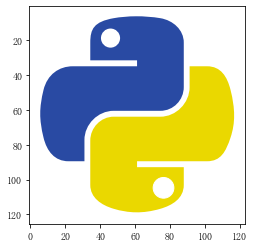

In [8]:
# #%fig=使用本書提供的read_svg_path()讀入SVG檔案中的路徑並顯示為Patch物件
from scpy2.matplotlib.svg_path import read_svg_path

ax = plt.gca()
patches = read_svg_path("python-logo.svg")
for patch in patches:
    ax.add_patch(patch)

ax.set_aspect("equal")
ax.invert_yaxis()
ax.autoscale();

### 集合

當需要繪製大量圖形時，可以使用從 `Collection` 類別衍生的各種集合物件。在繪製圖形時，`Collection` 物件會將其中多個儲存繪圖資訊的列表傳遞給 C++ 撰寫的繪圖函數，進一歩加強繪圖速度。表4-7列出了這些清單屬性，當清單長度不統一時，短清單中的元素將被循環使用。

表4-7 Collection 類別的清單屬性及說明
|屬性 |說明 |
|-----|-----|
|paths |繪圖路徑 |
|transforms |座標轉換物件 |
|edgecolors |邊線顏色 |
|facecolors |填充顏色 |
|linewidths  |邊線寬度 |
|offsets |座標偏移量 |

`Collection` 物件中的路徑從路徑座標到螢幕座標要進行三次座標轉換：
- `transform`: 主座標轉換。
- `transforms`: 與 `Collection` 中每條路徑對應的路徑轉換。
- `transOffset` 和 `offsets`: 座標偏移用的轉換物件和偏移量，對 `offsets` 中的每個座標採用 `transOffset` 進行座標轉換獲得實際的座標偏移量。

根據 `offset_position` 參數的值，分為以下兩種情況：`screen`(預設值) 和 `data`。
- `screen`: 座標轉換的順序為——路徑轉換、主轉換、座標偏移。
- `data`: 座標轉換的順序為——座標轉換、路徑轉換、主轉換。

下面透過幾個實例幫助讀者了解上述各種屬性和轉換。

#### 曲線集合(LineCollection)

在檔案 `butterfly.txt` 中每一行儲存一條幫閉曲線上各點的座標：x0, y0, x1, y1, x2, y2...。

❶ 在循環讀取這些座標時，將第一個點的座標增加到列表尾部。

❷ 將其轉為形狀為 `(N,2)` 的陣列，其中 N 為曲線上的點數加 1。

`lines` 是一個儲存多個陣列的清單，每個陣列表示一條曲線。可以透過 `LineCollection` 繪製 `lines` 儲存的曲線集合。

❸ `colors` 參數設定所有曲線的顏色為黑色。

❹ 也可以透過 `cmap` 參數設定所使用的顏色對映表，曲線的顏色由 `array` 參數陣列中的值和顏色對映表決定。這裡將曲線的點數作為顏色對映表的輸入值。

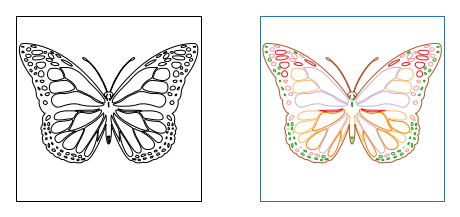

In [9]:
#%fig=使用LineCollection顯示大量曲線
from matplotlib import collections as mc
import numpy as np
lines = []
with open("butterfly.txt", "r") as f:
    for line in f:
        points = line.strip().split()
        points.extend(points[:2]) # ❶
        points = np.array(points).reshape(-1, 2) # ❷
        lines.append(points)
        
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
lc1 = mc.LineCollection(lines, colors="k", linewidths=1) # ❸
lc2 = mc.LineCollection(lines, cmap="Paired", linewidths=1, # ❹
                        array=np.log2(np.array([len(line) for line in lines])))
ax1.add_collection(lc1)
ax2.add_collection(lc2)

for ax in ax1, ax2:
    ax.set_aspect("equal")
    ax.autoscale()
    ax.axis("off")

`lc1` 和 `lc2` 中都有 145 條路徑， `lc1` 的 `edgecolors` 屬性長度為 1，因此所有的曲線都採用相同的顏色。而 `lc2` 的 `edgecolors` 屬性長度為 145，其中的每個顏色都是透過 `norm()` 和 `cmap()` 計算獲得的。

In [11]:
print("number of lc1 paths:", len(lc1.get_paths()))
print("number of lc1 colors:", len(lc1.get_edgecolors()))
print("number of lc2 colors:", len(lc2.get_edgecolors()))
print(np.all(lc2.get_edgecolors() == lc2.cmap(lc2.norm(lc2.get_array()))))

number of lc1 paths: 145
number of lc1 colors: 1
number of lc2 colors: 145
True


下面顯示路徑轉換、主轉換、座標偏移，可以看到唯一有作用的是主轉換，它就是資料座標轉換物件，它將曲線上各個點的座標從資料座標系轉換到螢幕座標系。

In [12]:
print(lc1.get_transforms()) # 路徑變換
print(lc1.get_transform() is ax1.transData) # 主變換為資料座標變換物件
print(lc1.get_offset_transform(), lc1.get_offsets())

[]
True
IdentityTransform() [[0. 0.]]


使用 `LineCollection` 可以繪製顏色或寬度漸層的曲線，例如下面對一個二維平面上的向量場積分，並將所得的路徑儲存到 `streams` 清單中。它的長度為 25，其中每個陣列表示一條積分數徑，形狀為 `(50,2)`。

In [13]:
from scipy.integrate import odeint

def field(s, t):
    x, y = s
    return 0.3 * x - y, 0.3 * y + x
    return [u, v]

X, Y = np.mgrid[-2:2:5j, -2:2:5j]
init_pos = np.c_[X.ravel(), Y.ravel()]
t = np.linspace(0, 5, 50)

streams = []
for pos in init_pos:
    r = odeint(field, pos, t)
    streams.append(r)

print(len(streams), streams[0].shape)

25 (50, 2)


為了採用漸層顏色顯示每條積分路徑，先將 `streams` 轉換成一個 3D 陣列 `lines` ，形狀為 `(25*(50-1), 2, 2)` ，也就是由 1225 條線段組成的集合。我們使用兩種數值作為顏色對映表的輸入：`time_value` 和 `speed_value` 。其中 `time_value` 為到達對應座標點所需的時間，`speed_value` 為對應座標點處的速度大小，效果如圖 4-20 所示。

In [14]:
# %hide
# %matplotlib_png

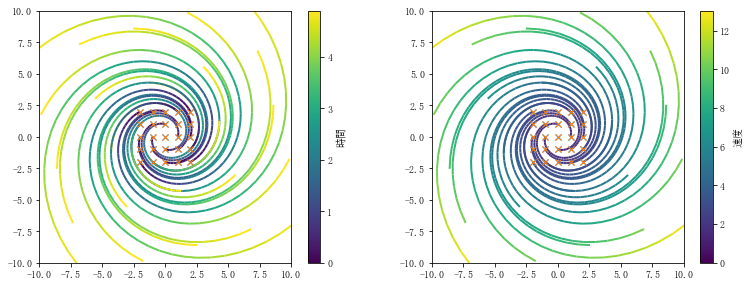

In [15]:
#%fig=使用LineCollection繪制彩色漸層的曲線
lines = np.concatenate([
    np.concatenate((r[:-1, None, :], r[1:, None, :]), axis=1)
    for r in streams], axis=0)

time_value = np.concatenate([t[:-1]] * len(streams))
x, y = lines.mean(axis=1).T
u, v = field([x, y], 0)
speed_value = np.sqrt(u ** 2 + v ** 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.5))
fig.subplots_adjust(0, 0, 1, 1)
ax1.plot(init_pos[:, 0], init_pos[:, 1], "x")
ax2.plot(init_pos[:, 0], init_pos[:, 1], "x")

lc1 = mc.LineCollection(lines, linewidths=2, array=time_value)
lc2 = mc.LineCollection(lines, linewidths=2, array=speed_value)

ax1.add_collection(lc1)
ax2.add_collection(lc2)

plt.colorbar(ax=ax1, mappable=lc1, label=u"時間")
plt.colorbar(ax=ax2, mappable=lc2, label=u"速度")

for ax in ax1, ax2:
    ax.plot(init_pos[:, 0], init_pos[:, 1], "x")
    ax.autoscale()
    ax.set_aspect("equal")
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)

In [13]:
#%hide
# %matplotlib_svg

#### 多邊形集合(PolyCollection)

多邊形集合 `PolyCollection` 的用法和 `LineCollection` 類似，不過它會自動封閉並填充顏色。下面的 `star_polygon()` 建立以 `(x,y)` 為中心、`r` 為半徑、旋轉 `theta` 的 N 角星，`s` 參數為內圓的半徑與外圓半徑的比值，效果如圖4-21所示。在隨機建立 1000 個 N 角星後，呼叫 `PolyCollection` 繪製。

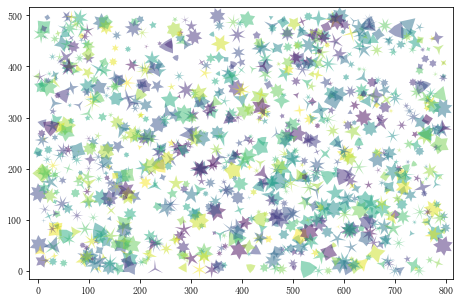

In [16]:
#%fig=用PolyCollection繪制大量多邊形
from numpy.random import randint, rand, uniform

def star_polygon(x, y, r, theta, n, s): 
    angles = np.arange(0, 2*np.pi, 2*np.pi/2/n) + theta
    xs = r * np.cos(angles)
    ys = r * np.sin(angles)
    xs[1::2] *= s
    ys[1::2] *= s
    xs += x
    ys += y
    return np.vstack([xs, ys]).T

stars = []
for i in range(1000):
    star = star_polygon(randint(800), randint(500), 
                        uniform(5, 20), uniform(0, 2*np.pi),
                        randint(3, 9), uniform(0.1, 0.7))
    stars.append(star)

fig, ax = plt.subplots(figsize=(10, 5))
polygons = mc.PolyCollection(stars, alpha=0.5, array=np.random.rand(len(stars)))
ax.add_collection(polygons)
ax.autoscale()
ax.margins(0)
ax.set_aspect("equal")

每個多邊形的填充顏色由顏色對映表決定，因此 `facecolors` 的長度與多邊形的個數相同，而所有的多邊形共用邊線顏色，所以 `edgecolors` 的長度為 1。`PolyCollection` 的座標轉換方式與 `LineCollection` 相同，就不再重複了。

In [17]:
print("length of facecolors:", len(polygons.get_facecolors()))
print("length of edgecolors:", len(polygons.get_edgecolors()))

length of facecolors: 1000
length of edgecolors: 0


#### 路徑集合(PathCollection)

`scatter()` 用於繪製雜湊圖，它傳回的是一個 `PathCollection` 物件：

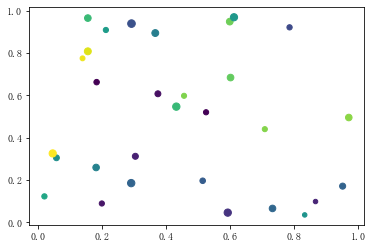

In [18]:
#%nofig
N = 30
np.random.seed(42)
x = np.random.rand(N)
y = np.random.rand(N)
size = np.random.randint(20, 60, N)
value = np.random.rand(N)

fig, ax = plt.subplots()
pc = ax.scatter(x, y, s=size, c=value)

`pc` 是一個 `PathCollection` 物件，它的 `facecolors` 長度為雜湊點數，顏色由顏色對映表決定。`edgecolors` 的長度為 1，所以每個圓形的邊線顏色相同。

所有雜湊點的形狀都相似的，因此 `paths` 屬性的長度為 1。每個雜湊點的大小由路徑轉換 `transforms` 決定，它是一個形狀為 `(30, 3, 3)` 的 3D 陣列。每個雜湊點對應其中的 3x3 的轉換矩陣。下面是索引為 0 的雜湊點的路徑轉換物件，它將路徑在 X 軸和 Y 軸方向上放大 5.916 倍：

In [19]:
print(pc.get_transforms().shape)
print(pc.get_transforms()[0]) #索引為0的點對應的縮放矩陣

(30, 3, 3)
[[5.91607978 0.         0.        ]
 [0.         5.91607978 0.        ]
 [0.         0.         1.        ]]


雜湊點的中心位置為 `offsets` 經過 `offset_tranform` 轉換之後的座標。由下面的結果可以看出 `offset_transform` 轉換就是資料座標轉換物件，它將資料空間中的座標轉為以像素為單位的螢幕座標，因此 `offsets` 中儲存的就是資料座標系中的座標偏移量。 

In [20]:
print(pc.get_offsets()[0]) #索引為0的點對應的中心座標
#計算索引為0的點對應的螢幕座標
print(pc.get_offset_transform().transform(pc.get_offsets())[0])
print(pc.get_offset_transform() is ax.transData)

[0.3745401188473625 0.6075448519014384]
[182.70005619055019 167.03188992733877]
True


`transforms` 決定雜湊點的大小，`offset_transform` 和 `offsets` 決定雜湊點的位置，因此主轉換 `transform` 物件無須做任何轉換，它是一個恆等轉換。

In [21]:
print(pc.get_transform())

IdentityTransform()


由於 `offset_position` 的值為 `screen` ，因此座標轉換的順序為：路徑轉換、主轉換、座標偏移。路徑轉換為單位圓進行縮放，而座標偏移則把圓形移動到指定的位置。

In [22]:
pc.get_offset_position()

<ipython-input-22-3fcdc85916f2>:1: MatplotlibDeprecationWarning: 
The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  pc.get_offset_position()


'screen'

#### 橢圓集合(EllipseCollection)

`EllipseCollection` 用於繪製大量的橢圓，每個橢圓都可以擁有獨立的長軸和短軸長度以及旋轉角度。它的參數如下：
```
EllipseCollection(self, widths, heights, angles, units='points', **kwargs)
```

其中 `widths`, `heights`, `angles` 是三個長度相同的陣列，分別為每個橢圓的兩個軸的長度以及旋轉角度。而 `units` 參數則指定 `widths` 和 `heights` 的單位，有以下選項：

```
'points' | 'inches' | 'dots' | 'width' | 'height' | 'x' | 'y' | 'xy'
```

其中 `points`, `inches`, `dots` 為螢幕座標系中的長度，`dots` 的單位為像素點，而 `points`, `inches` 則根據圖表物件的 `DPI` 屬性按照不同的比例轉為 `dots` 單位。`width`, `height` 分別用子圖的寬度或高度作為長度單位，`x`, `y` 則採用資料座標系中的 X 軸或 Y 軸長度，`xy` 表示採用資料座標系中的 X 軸和 Y 軸的長度單位。如果子圖的 X 軸和 Y 軸長度單位不同，橢圓呈現的旋轉角度與 `angles` 指定的值也會有所不同。

下面的程式示範了 `unit` 為 'x' 和 'xy' 的區別，效果如圖4-22所示，左圖中橢圓的長度單位為 'x'，寬度為 X 軸上的兩個單位距離，高度為 X 軸上的單位距離。由於高度和寬度採用同樣的單位，因此橢圓顯示的角度與 `angles` 指定的值相同。當 `unit` 為 'xy' 時，橢圓的高度採用 Y 軸的單位距離，由於 Y 軸的單位距離的像素點數小於 X 軸的單位距離，因此右圖中的橢圓比左圖的更扁一些，而且由於兩個方向上的長度單位不同，橢圓呈現的方向也與 `angles` 指定的值不同。如果使用 `axes[1].set_aspect("equal")` 將 X 和 Y 軸的單位長度設定為相同，則橢圓的角度和 `angles` 指定的角度相同，圖中的 12 個橢圓將均勻地分佈在一個正圓的圓周上。

(-5.0, 5.0, -5.0, 5.0)

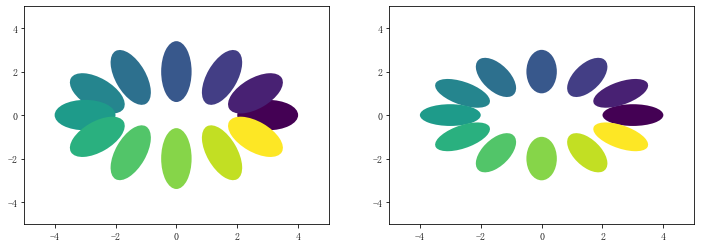

In [23]:
#%fig=`EllipseColletion`的`unit`參數：`unit='x'`（左圖）、`unit='xy'`（右圖）
angles = np.linspace(0, 2*np.pi, 12, endpoint=False)
offsets = np.c_[3*np.cos(angles), 2*np.sin(angles)]
angles_deg = np.rad2deg(angles)
widths = np.full_like(angles, 2)
heights = np.full_like(angles, 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ec0 = mc.EllipseCollection(widths, heights, angles_deg, units="x", array=angles,
                          offsets=offsets, transOffset=axes[0].transData)
axes[0].add_collection(ec0)
axes[0].axis((-5, 5, -5, 5))

ec1 = mc.EllipseCollection(widths, heights, angles_deg, units="xy", array=angles,
                          offsets=offsets, transOffset=axes[1].transData)
axes[1].add_collection(ec1)
axes[1].axis((-5, 5, -5, 5))
#axes[1].set_aspect("equal");

#### 資料空間中的圓形集合物件

仿照圖4-22(右)，可以使用 `EllipseCollection` 繪製以資料空間中的長度為半徑的圓的集合，只需要將 `widths` 和 `heights` 設定為圓形的直徑即可。雖然在 `collections` 模組中還有一個 `CircleCollection` 類別，但是它所設定的圓的大小是螢幕空間的大小，無法控制其在資料空間中的大小。

下面我們自訂一個能繪製資料空間中圓形集合的 `DataCircleCollection` 類別：

In [24]:
from matplotlib.collections import CircleCollection, Collection
from matplotlib.transforms import Affine2D

class DataCircleCollection(CircleCollection):

    def set_sizes(self, sizes):
        self._sizes = sizes

    def draw(self, render):
        ax = self.axes
        ms = np.zeros((len(self._sizes), 3, 3))
        ms[:, 0, 0] = self._sizes
        ms[:, 1, 1] = self._sizes
        ms[:, 2, 2] = 1
        self._transforms = ms #❶

        m = ax.transData.get_affine().get_matrix().copy()
        m[:2, 2:] = 0
        self.set_transform(Affine2D(m)) #❷

        return Collection.draw(self, render)

❶ 設定每個圓形對應的路徑轉換，它們將圓形縮放指定的倍數。

❷ 使用資料座標轉換物件的縮放係數建立一個新的二維仿射轉換物件，並將其設定為主轉換。路徑轉換與主轉換重疊起來，就將半徑為 1 的單位圓縮放為資料空間中半徑為 `sizes` 的圓形。

每個圓形對應的路徑轉換將單位圓轉為資料座標系中指定大小的圓形，然後透過主座標轉換將資料座標系中的圓形轉為螢幕座標系中的大小，最後再由座標偏移轉換為圓形放到指定的位置。

下面用 `DataCircleCollection` 繪製一幅漂亮的圓形拼圖，效果如圖4-23 所示。"venus-face.csv" 中的每一行有 6 個數值表示一個圓形，每個數值的含義為：圓形 X 軸座標, 圓形 Y 軸座標, 半徑, 紅色, 綠色, 藍色。

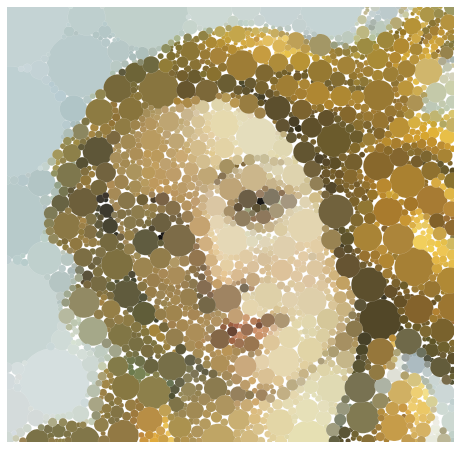

In [25]:
#%fig=使用DataCircleCollection繪制大量的圓形
data = np.loadtxt("venus-face.csv", delimiter=",")
offsets = data[:, :2]
sizes = data[:, 2] * 1.05
colors = data[:, 3:] / 256.0

fig, axe = plt.subplots(figsize=(8, 8))
axe.set_rasterized(True)
cc = DataCircleCollection(sizes, facecolors=colors, edgecolors="w", linewidths=0.1,
                          offsets=offsets, transOffset=axe.transData)

axe.add_collection(cc)
axe.axis((0, 512, 512, 0))
axe.axis("off");